# ARPA Lombardia Ground Sensors data request notebook

This notebook is used to download data from both meteorological and air quality ground sensor of ARPA Lombardia network segment.

In detail, each sensor type, position and time serie are retrieved as it follows:
- Ground sensor's type and position is always retrived through the ARPA API: [Air quality stations](https://www.dati.lombardia.it/Ambiente/Stazioni-qualit-dell-aria/ib47-atvt) and [Meteorological stations](https://www.dati.lombardia.it/Ambiente/Stazioni-Meteorologiche/nf78-nj6b)
- Time series are available through API request for the current year only (e.g. from Jenuary 2022 if current year is 2022) for both [Air quality data](https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria/nicp-bhqi) and  [Meteorological data](https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo/647i-nhxk). (this may change in future).
- To use data from previous years it's required to use the dataset in .csv format, such as [Air quality data for 2020]( https://www.dati.lombardia.it/Ambiente/Dati-sensori-aria-2020/88sp-5tmj) or [Meteorological data for 2020](https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo-2020/erjn-istm). The **ARPA_URL_by_year** function contains the links to .csv data for each year. to allow automatic download and preprocessing.

In this notebook sensors position and types are retrieved from the API only, while time series can retreived by .csv or API depending on the decided year (if before 2022 is only possible to use the .csv file, while for 2022 data from API are available).

Changing weeks numbers and year the code will automatically consider the right data source (API or .csv).




At the end of the notebook there is a function where ground sensor data interpolation is performed using Radial Basis Function (RBF) method (from [Scipy](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.Rbf.html) library) over the region of interest.

### Reference:
ARPA data a from API are accessible using [Socrata Open Data API](https://dev.socrata.com/). <br>
The library [sodapy](https://github.com/xmunoz/sodapy) is a python client for the Socrata Open Data API.
The "app_token" is required to access the data. <br>
Example video tutorial: https://www.youtube.com/watch?v=3p4gncGaSeg&t=899s&ab_channel=CharmingData <br>
Register on "Open Data Lombardia" to get tokens: https://www.dati.lombardia.it/login

## Import libraries

In [1]:
from sodapy import Socrata
import pandas as pd
import geopandas as gpd
import os
import zipfile
import requests
import json
import io
from scipy import stats
import numpy as np
import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
import ipywidgets as widgets

# Set current working directory
cwd = os.getcwd()

# Import functions defined for DDUST project:
from functions import my_methods

Modify **date.json** file to change the date:

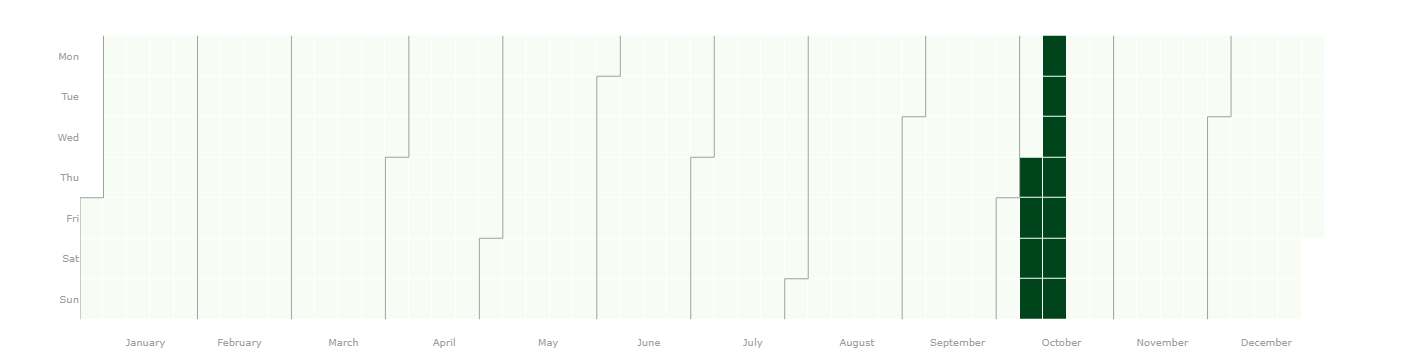

In [2]:
d = open('date.json')
date = json.load(d)
year = date['year']
custom_week = date['custom_week']
calendar = my_methods.manuring_periods(year, custom_week)

In [3]:
# Select start and end date of the corresponding selected week:
start_date = datetime.datetime.strptime((str(year)+'-'+custom_week[0]), "%Y-%m-%d").date()
end_date = datetime.datetime.strptime((str(year)+'-'+custom_week[1]), "%Y-%m-%d").date()
print("The starting date is", start_date,"and the ending date is" , end_date,". The date is define as yyyy-mm-dd.")

The starting date is 2021-10-07 and the ending date is 2021-10-17 . The date is define as yyyy-mm-dd.


In [4]:
# Extract start, end dates and selected year for ARPA sensor. This is done to consider also the last day in the computation, otherwise it won't be used for the calculations
start_date_dt = datetime.datetime.strptime((str(year)+'-'+custom_week[0]), '%Y-%m-%d')
end_date_dt = datetime.datetime.strptime((str(year)+'-'+custom_week[1]), '%Y-%m-%d')+timedelta(days=1) #increase 1 day to select data from arpa sensor correctly
start_date = str(start_date_dt)[0:10]
end_date = str(end_date_dt)[0:10]
year = datetime.datetime.strptime(start_date, '%Y-%m-%d').date().year

# Key and app token for Socrata API
f = open('keys.json')
keys = json.load(f)

#Z-Score threshold
threshold = 4  

----

# Import meteorological stations from ARPA API

https://www.dati.lombardia.it/Ambiente/Dati-sensori-meteo-2020/erjn-istm

In [5]:
arpa_domain = "www.dati.lombardia.it"
m_st_descr = "nf78-nj6b"
client = Socrata(arpa_domain, app_token = keys['arpa_token'])
results = client.get_all(m_st_descr)
meteo_st_descr = pd.DataFrame(results)
meteo_st_descr["idsensore"] = meteo_st_descr["idsensore"].astype(int)

In [6]:
meteo_st_descr

idsensore           tipologia unit_dimisura idstazione  \
0           100      Precipitazione            mm         52   
1           101        Altezza Neve            cm         52   
2         10373      Precipitazione            mm        687   
3         10376      Precipitazione            mm        706   
4         10377         Temperatura            °C        706   
...         ...                 ...           ...        ...   
1257         99         Temperatura            °C         52   
1258       9933      Precipitazione            mm        677   
1259       9935  Radiazione Globale          W/m²        677   
1260       9938         Temperatura            °C        677   
1261       9939    Umidità Relativa             %        677   

                      nomestazione quota provincia                datastart  \
0               Grosio Diga Fusino  1220        SO  2002-01-01T00:00:00.000   
1               Grosio Diga Fusino  1220        SO  2001-12-01T00:00:00.000   
2                   Ferno v.Di Dio   215        VA  2007-08-13T00:00:00.000   
3                     Lecco v.Sora   272        LC  2008-07-22T00:00:00.000   
4                     Lecco v.Sora   272        LC  2008-07-22T00:00:00.000   
...                            ...   ...       ...                      ...   
1257            Grosio Diga Fusino  1220        SO  2001-12-01T00:00:00.000   
1258  Cremona Via Fatebenefratelli    43        CR  2006-04-10T00:00:00.000   
1259  Cremona Via Fatebenefratelli    43        CR  2006-04-10T00:00:00.000   
1260  Cremona Via Fatebenefratelli    43        CR  2006-04-10T00:00:00.000   
1261  Cremona Via Fatebenefratelli    43        CR  2006-04-10T00:00:00.000   

     storico cgb_nord cgb_est                 lng                 lat  \
0          N  5131141  595908  10.245970197827939  46.327055775545546   
1          N  5131141  595908  10.245970197827939  46.327055775545546   
2          N  5051773  481053   8.756970445453431   45.61924377994763   
3          N  5078987  531045   9.399950344681852   45.86374884127965   
4          N  5078987  531045   9.399950344681852   45.86374884127965   
...      ...      ...     ...                 ...                 ...   
1257       N  5131141  595908  10.245970197827939  46.327055775545546   
1258       N  4999315  582066  10.043836158369393   45.14254063221695   
1259       N  4999315  582066  10.043836158369393   45.14254063221695   
1260       N  4999315  582066  10.043836158369393   45.14254063221695   
1261       N  4999315  582066  10.043836158369393   45.14254063221695   

                                               location  \
0     {'latitude': '46.327055775545546', 'longitude'...   
1     {'latitude': '46.327055775545546', 'longitude'...   
2     {'latitude': '45.61924377994763', 'longitude':...   
3     {'latitude': '45.86374884127965', 'longitude':...   
4     {'latitude': '45.86374884127965', 'longitude':...   
...                                                 ...   
1257  {'latitude': '46.327055775545546', 'longitude'...   
1258  {'latitude': '45.14254063221695', 'longitude':...   
1259  {'latitude': '45.14254063221695', 'longitude':...   
1260  {'latitude': '45.14254063221695', 'longitude':...   
1261  {'latitude': '45.14254063221695', 'longitude':...   

     :@computed_region_6hky_swhk :@computed_region_ttgh_9sm5 datastop  
0                              3                           3      NaN  
1                              3                           3      NaN  
2                              1                           1      NaN  
3                             10                          10      NaN  
4                             10                          10      NaN  
...                          ...                         ...      ...  
1257                           3                           3      NaN  
1258                           8                           8      NaN  
1259                           8                      

---

# Import Meteorological data from ARPA API (current year data) or .csv file (past years)

In [7]:
# If current year use data from API
if int(year) == datetime.datetime.today().year:
    arpa_domain = "www.dati.lombardia.it"
    dati = "647i-nhxk" #change this depending on the dataset (check Open Data Lombardia datasets)
    client = Socrata(arpa_domain, app_token = keys['arpa_token']) #insert your arpa_token
    date_query = "data > {} and data < {}".format('"'+ start_date + '"','"'+ end_date + '"')
    results = client.get(dati, where=date_query, limit=5000000000000)
    meteo_data = pd.DataFrame(results)
    meteo_data.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    meteo_data['data'] =  pd.to_datetime(meteo_data['data'], format='%Y/%m/%d %H:%M:%S')
    meteo_data = meteo_data.astype({"idsensore": int,"valore": float})
    
# If previous years download the corresponding year .csv file and filter the dates  
elif int(year) < datetime.datetime.today().year:
    filename_meteo = 'meteo_'+str(year)+'.zip'
    if not os.path.exists(os.path.join(filename_meteo)):
        csv_url = my_methods.meteo_sensor(str(year))
        r_meteo = requests.get(csv_url, allow_redirects=True)
        DL_zip = open(filename, 'wb').write(r_meteo.content)
        print('Dowloaded zip file')
    
    print('Zip file exist')
    archive = zipfile.ZipFile(filename_meteo, 'r')
    data = archive.open(str(year)+'.csv') 
    # Keep meteo_data_df in memory so is possible to use it for other time periods
    meteo_data_df = pd.read_csv(data, dtype={"IdSensore": int,"Valore": float, "Stato": str, "idOperatore":str})
    meteo_data_df.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    meteo_data_df['data'] =  pd.to_datetime(meteo_data_df['data'], format='%d/%m/%Y %H:%M:%S')

Zip file exist


In [8]:
# Filter .csv data in meteo_data_df dataframe for the time range required
# Skip if data obtained from API
mask = (meteo_data_df.data >= start_date) & (meteo_data_df.data < end_date)
meteo_data = meteo_data_df.loc[mask]

- - -

# Meteorological data processing 

Drop "stato", "idoperatore" columns and select valid data different from -9999:

In [9]:
meteo_data = meteo_data.drop(columns=['stato', 'idoperatore'])
meteo_data = meteo_data[meteo_data.valore.astype(float) != -9999]

In [10]:
meteo_data

idsensore                data  valore
45533873          3 2021-10-07 00:00:00    38.0
45533874          6 2021-10-07 00:00:00    16.1
45533875          9 2021-10-07 00:00:00     0.0
45533876         11 2021-10-07 00:00:00     0.0
45533877         13 2021-10-07 00:00:00     8.6
...             ...                 ...     ...
47373085      32413 2021-10-17 23:50:00     0.0
47373086       5078 2021-10-17 23:50:00    32.2
47373087       5080 2021-10-17 23:50:00    65.6
47373088       5082 2021-10-17 23:50:00    52.2
47373089      30523 2021-10-17 23:55:00     8.6

[1839217 rows x 3 columns]

Get sensors unique types:

In [11]:
meteo_st_descr.tipologia.unique()

array(['Precipitazione', 'Altezza Neve', 'Temperatura',
       'Umidità Relativa', 'Radiazione Globale', 'Direzione Vento',
       'Velocità Vento', 'Livello Idrometrico'], dtype=object)

Select sensors adding to the following list:

In [12]:
m_sensor_sel = ['Precipitazione','Temperatura','Umidità Relativa','Direzione Vento','Velocità Vento', 'Radiazione Globale']

Join sensors description and information:

In [13]:
meteo_table = pd.merge(meteo_data, meteo_st_descr, on = 'idsensore')

Select sensor by type:

In [14]:
meteo_table['tipologia'].astype(str)
meteo_table = meteo_table[meteo_table['tipologia'].isin(m_sensor_sel)]

In [15]:
temp_st = meteo_table.loc[meteo_table['tipologia'] == 'Temperatura']
prec_st = meteo_table.loc[meteo_table['tipologia'] == 'Precipitazione']
air_hum_st = meteo_table.loc[meteo_table['tipologia'] == 'Umidità Relativa']
wind_dir_st = meteo_table.loc[meteo_table['tipologia'] == 'Direzione Vento']
wind_speed_st = meteo_table.loc[meteo_table['tipologia'] == 'Velocità Vento']
rad_glob_st = meteo_table.loc[meteo_table['tipologia'] == 'Radiazione Globale']

Calculate Z-Score to remove outliers and calculate mean:

In [16]:
temp_st['zscore'] = np.abs(stats.zscore(temp_st['valore'], nan_policy='propagate'))
temp_st = temp_st[temp_st.zscore < threshold]
temp_st = temp_st.groupby(['idsensore'],as_index=False).mean()
temp_st = pd.merge(temp_st, meteo_st_descr, on = 'idsensore')

In [17]:
# precipitation values less than 100 to remove outliers
prec_st = prec_st[prec_st.valore < 100]
prec_st = prec_st.groupby(['idsensore'],as_index=False).mean()
prec_st = pd.merge(prec_st, meteo_st_descr, on = 'idsensore')

In [18]:
air_hum_st['zscore'] = np.abs(stats.zscore(air_hum_st['valore'], nan_policy='propagate'))
air_hum_st = air_hum_st[air_hum_st.zscore < threshold]
air_hum_st = air_hum_st.groupby(['idsensore'],as_index=False).mean()
air_hum_st = pd.merge(air_hum_st, meteo_st_descr, on = 'idsensore')

In [19]:
rad_glob_st['zscore'] = np.abs(stats.zscore(rad_glob_st['valore'], nan_policy='propagate'))
rad_glob_st = rad_glob_st[rad_glob_st.zscore < threshold]
rad_glob_st = rad_glob_st.groupby(['idsensore'],as_index=False).mean()
rad_glob_st = pd.merge(rad_glob_st, meteo_st_descr, on = 'idsensore')

In [20]:
wind_dir_st['zscore'] = np.abs(stats.zscore(wind_dir_st['valore'], nan_policy='propagate'))
wind_dir_st = wind_dir_st[wind_dir_st.zscore < threshold]
wind_dir_st = wind_dir_st.groupby('idsensore')['valore'].apply(lambda x: x.mode().iat[0]).reset_index()
wind_dir_st = pd.merge(wind_dir_st, meteo_st_descr, on = 'idsensore')

In [21]:
wind_speed_st['zscore'] = np.abs(stats.zscore(wind_speed_st['valore'], nan_policy='propagate'))
wind_speed_st = wind_speed_st[wind_speed_st.zscore < threshold]
wind_speed_st = wind_speed_st.groupby(['idsensore'],as_index=False).mean()
wind_speed_st = pd.merge(wind_speed_st, meteo_st_descr, on = 'idsensore')

Save sensors separately and create a .gpkg file for each one:

In [22]:
temp_gdf = gpd.GeoDataFrame(temp_st, geometry=gpd.points_from_xy(temp_st.lng, temp_st.lat))
temp_gdf = temp_gdf.set_crs('epsg:4326')
prec_gdf = gpd.GeoDataFrame(prec_st, geometry=gpd.points_from_xy(prec_st.lng, prec_st.lat))
prec_gdf = prec_gdf.set_crs('epsg:4326')
air_hum_gdf = gpd.GeoDataFrame(air_hum_st, geometry=gpd.points_from_xy(air_hum_st.lng, air_hum_st.lat))
air_hum_gdf = air_hum_gdf.set_crs('epsg:4326')
wind_dir_gdf = gpd.GeoDataFrame(wind_dir_st, geometry=gpd.points_from_xy(wind_dir_st.lng, wind_dir_st.lat))
wind_dir_gdf = wind_dir_gdf.set_crs('epsg:4326')
wind_speed_gdf = gpd.GeoDataFrame(wind_speed_st, geometry=gpd.points_from_xy(wind_speed_st.lng, wind_speed_st.lat))
wind_speed_gdf = wind_speed_gdf.set_crs('epsg:4326')
rad_glob_gdf = gpd.GeoDataFrame(rad_glob_st, geometry=gpd.points_from_xy(rad_glob_st.lng, rad_glob_st.lat))
rad_glob_gdf = rad_glob_gdf.set_crs('epsg:4326')

Save in a **temp** folder:

In [23]:
temp_gdf.to_file(cwd+"/temp/temp_st.gpkg", driver="GPKG")
prec_gdf.to_file(cwd+"/temp/prec_st.gpkg", driver="GPKG")
air_hum_gdf.to_file(cwd+"/temp/air_hum_st.gpkg", driver="GPKG")
wind_dir_gdf.to_file(cwd+"/temp/wind_dir_st.gpkg", driver="GPKG")
wind_speed_gdf.to_file(cwd+"/temp/wind_speed_st.gpkg", driver="GPKG")
rad_glob_gdf.to_file(cwd+"/temp/rad_glob_st.gpkg", driver="GPKG")

---

# Import stations and sensor type from ARPA API

Import sensors description and position from the API: https://www.dati.lombardia.it/Ambiente/Stazioni-qualit-dell-aria/ib47-atvt

In [24]:
arpa_domain = "www.dati.lombardia.it"
st_descr = "ib47-atvt"

client = Socrata(arpa_domain, app_token = keys['arpa_token']) 
results = client.get_all(st_descr)

air_st_descr = pd.DataFrame(results)
air_st_descr["idsensore"] = air_st_descr["idsensore"].astype(int)

- - - 

# Import Air Quality data from ARPA API (current year data) or .csv file (past years)

In [25]:
# If current year use data from API
if int(year) == datetime.datetime.today().year:
    arpa_domain = "www.dati.lombardia.it"
    dati = "nicp-bhqi" #change this depending on the dataset (check Open Data Lombardia datasets)
    client = Socrata(arpa_domain, app_token = keys['arpa_token'])
    date_query = "data > {} and data < {}".format('"'+ start_date + '"','"'+ end_date + '"')  #select date 
    results = client.get(dati, where=date_query, limit=5000000000)  # query
    aq_data = pd.DataFrame(results) #create Dataframe
    aq_data.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    aq_data['data'] =  pd.to_datetime(aq_data['data'], format='%Y/%m/%d %H:%M:%S')
    aq_data = aq_data.astype({"idsensore": int,"valore": float})
    
# If previous years download the corresponding year .csv file and filter the dates  
elif int(year) < datetime.datetime.today().year:
    filename_aq = 'aq_'+str(year)+'.zip'
    if not os.path.exists(os.path.join(filename_aq)):
        csv_url = my_methods.AQ_sensor(str(year))
        r_aq = requests.get(csv_url, allow_redirects=True)
        DL_zip = open(filename_aq, 'wb').write(r_aq.content)
        print('Dowloaded zip file')
    
    print('Zip file exist')
    archive = zipfile.ZipFile('aq_'+str(year)+'.zip', 'r')
    data = archive.open(str(year)+'.csv') #open the zip
    aq_data_df=pd.read_csv(data)
    aq_data_df.rename(columns={'IdSensore': 'idsensore','Data': 'data','idOperatore': 'idoperatore','Stato': 'stato','Valore': 'valore'}, inplace=True)
    aq_data_df['data'] =  pd.to_datetime(aq_data_df['data'], format='%d/%m/%Y %H:%M:%S')

Zip file exist


In [26]:
mask = (aq_data_df.data >= start_date) & (aq_data_df.data < end_date)
aq_data = aq_data_df.loc[mask]

- - -

# Air quality data processing

Drop "stato" and "idoperatore" columns and select valid values different from -9999:

In [27]:
aq_data = aq_data.drop(columns=['stato', 'idoperatore'])
aq_data = aq_data[aq_data.valore.astype(float) != -9999]

Get the unique sensor type names:

In [28]:
air_st_descr.nometiposensore.unique()

array(['Ossidi di Azoto', 'Monossido di Carbonio', 'Biossido di Azoto',
       'Biossido di Zolfo', 'Particelle sospese PM2.5', 'Benzene',
       'Ozono', 'PM10 (SM2005)', 'Particolato Totale Sospeso',
       'Ammoniaca', 'Nikel', 'Arsenico', 'Cadmio', 'Piombo',
       'Benzo(a)pirene', 'BlackCarbon', 'Monossido di Azoto', 'PM10'],
      dtype=object)

In [29]:
sensor_sel = ['Ossidi di Azoto', 'Monossido di Carbonio', 'Biossido di Azoto','Ozono',
       'Biossido di Zolfo', 'Particelle sospese PM2.5','Ammoniaca','PM10 (SM2005)']

Join sensors description and information with the mean value:

In [30]:
aq_table = pd.merge(aq_data, air_st_descr, on='idsensore')

Select sensors adding their names to the list:

In [31]:
aq_table['nometiposensore'].astype(str)
aq_table = aq_table[aq_table['nometiposensore'].isin(sensor_sel)]

In [32]:
pm25_st = aq_table.loc[aq_table['nometiposensore'] == 'Particelle sospese PM2.5']
co_st = aq_table.loc[aq_table['nometiposensore'] == 'Monossido di Carbonio']
no2_st = aq_table.loc[aq_table['nometiposensore'] == 'Biossido di Azoto']
so2_st = aq_table.loc[aq_table['nometiposensore'] == 'Biossido di Zolfo']
nh3_st = aq_table.loc[aq_table['nometiposensore'] == 'Ammoniaca']
nox_st = aq_table.loc[aq_table['nometiposensore'] == 'Ossidi di Azoto']
pm10_st = aq_table.loc[aq_table['nometiposensore'] == 'PM10 (SM2005)']
o3_st = aq_table.loc[aq_table['nometiposensore'] == 'Ozono']

Z-Test to remove outliers and calculate mean:

In [33]:
pm25_st['zscore'] = np.abs(stats.zscore(pm25_st['valore'], nan_policy='propagate'))
pm25_st = pm25_st[pm25_st.zscore < threshold]
pm25_st = pm25_st.groupby(['idsensore'],as_index=False).mean()
pm25_st = pd.merge(pm25_st, air_st_descr, on='idsensore')

In [34]:
co_st['zscore'] = np.abs(stats.zscore(co_st['valore'], nan_policy='propagate'))
co_st = co_st[co_st.zscore < threshold]
co_st = co_st.groupby(['idsensore'],as_index=False).mean()
co_st = pd.merge(co_st, air_st_descr, on='idsensore')

In [35]:
no2_st['zscore'] = np.abs(stats.zscore(no2_st['valore'], nan_policy='propagate'))
no2_st = no2_st[no2_st.zscore < threshold]
no2_st = no2_st.groupby(['idsensore'],as_index=False).mean()
no2_st = pd.merge(no2_st, air_st_descr, on='idsensore')

In [36]:
so2_st['zscore'] = np.abs(stats.zscore(so2_st['valore'], nan_policy='propagate'))
so2_st = so2_st[so2_st.zscore < threshold]
so2_st = so2_st.groupby(['idsensore'],as_index=False).mean()
so2_st = pd.merge(so2_st, air_st_descr, on='idsensore')

In [37]:
nh3_st['zscore'] = np.abs(stats.zscore(nh3_st['valore'], nan_policy='propagate'))
nh3_st = nh3_st[nh3_st.zscore < threshold]
nh3_st = nh3_st.groupby(['idsensore'],as_index=False).mean()
nh3_st = pd.merge(nh3_st, air_st_descr, on='idsensore')

In [38]:
nox_st['zscore'] = np.abs(stats.zscore(nox_st['valore'], nan_policy='propagate'))
nox_st = nox_st[nox_st.zscore < threshold]
nox_st = nox_st.groupby(['idsensore'],as_index=False).mean()
nox_st = pd.merge(nox_st, air_st_descr, on='idsensore')

In [39]:
pm10_st['zscore'] = np.abs(stats.zscore(pm10_st['valore'], nan_policy='propagate'))
pm10_st = pm10_st[pm10_st.zscore < threshold]
pm10_st = pm10_st.groupby(['idsensore'],as_index=False).mean()
pm10_st = pd.merge(pm10_st, air_st_descr, on='idsensore')

In [40]:
o3_st['zscore'] = np.abs(stats.zscore(o3_st['valore'], nan_policy='propagate'))
o3_st = o3_st[o3_st.zscore < threshold]
o3_st = o3_st.groupby(['idsensore'],as_index=False).mean()
o3_st = pd.merge(o3_st, air_st_descr, on='idsensore')

Save sensors separately and create a .gpkg file for each one:

In [41]:
pm25_gdf = gpd.GeoDataFrame(pm25_st, geometry=gpd.points_from_xy(pm25_st.lng, pm25_st.lat))
pm25_gdf = pm25_gdf.set_crs('epsg:4326')
co_gdf = gpd.GeoDataFrame(co_st, geometry=gpd.points_from_xy(co_st.lng, co_st.lat))
co_gdf = co_gdf.set_crs('epsg:4326')
no2_gdf = gpd.GeoDataFrame(no2_st, geometry=gpd.points_from_xy(no2_st.lng, no2_st.lat))
no2_gdf = no2_gdf.set_crs('epsg:4326')
so2_gdf = gpd.GeoDataFrame(so2_st, geometry=gpd.points_from_xy(so2_st.lng, so2_st.lat))
so2_gdf = so2_gdf.set_crs('epsg:4326')
nh3_gdf = gpd.GeoDataFrame(nh3_st, geometry=gpd.points_from_xy(nh3_st.lng, nh3_st.lat))
nh3_gdf = nh3_gdf.set_crs('epsg:4326')
nox_gdf = gpd.GeoDataFrame(nox_st, geometry=gpd.points_from_xy(nox_st.lng, nox_st.lat))
nox_gdf = nox_gdf.set_crs('epsg:4326')
pm10_gdf = gpd.GeoDataFrame(pm10_st, geometry=gpd.points_from_xy(pm10_st.lng, pm10_st.lat))
pm10_gdf = pm10_gdf.set_crs('epsg:4326')
o3_gdf = gpd.GeoDataFrame(o3_st, geometry=gpd.points_from_xy(o3_st.lng, o3_st.lat))
o3_gdf = o3_gdf.set_crs('epsg:4326')

Save in a **temp** folder:

In [42]:
pm25_gdf.to_file(cwd+"/temp/pm25_st.gpkg", driver="GPKG")
co_gdf.to_file(cwd+"/temp/co_st.gpkg", driver="GPKG")
no2_gdf.to_file(cwd+"/temp/no2_st.gpkg", driver="GPKG")
so2_gdf.to_file(cwd+"/temp/so2_st.gpkg", driver="GPKG")
nh3_gdf.to_file(cwd+"/temp/nh3_st.gpkg", driver="GPKG")
nox_gdf.to_file(cwd+"/temp/nox_st.gpkg", driver="GPKG")
pm10_gdf.to_file(cwd+"/temp/pm10_st.gpkg", driver="GPKG")
o3_gdf.to_file(cwd+"/temp/o3_st.gpkg", driver="GPKG")

---

# Sensor interpolation using Radial Basis Functions (RBF)

Only ARPA sensors are interpolated because ESA Air Quality Platforms are few

In [43]:
from osgeo import gdal
from osgeo import ogr
import rasterio as rio
from rasterio.transform import Affine
from rasterio.crs import CRS
import matplotlib.pyplot as plt
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

In [44]:
pm25_gdf = pm25_gdf.to_crs('epsg:32632')
co_gdf = co_gdf.to_crs('epsg:32632')
no2_gdf = no2_gdf.to_crs('epsg:32632')
so2_gdf = so2_gdf.to_crs('epsg:32632')
nh3_gdf = nh3_gdf.to_crs('epsg:32632')
nox_gdf = nox_gdf.to_crs('epsg:32632')
pm10_gdf = pm10_gdf.to_crs('epsg:32632')
o3_gdf = o3_gdf.to_crs('epsg:32632')

In [45]:
temp_gdf = temp_gdf.to_crs('epsg:32632')
prec_gdf = prec_gdf.to_crs('epsg:32632')
air_hum_gdf = air_hum_gdf.to_crs('epsg:32632')
wind_dir_gdf = wind_dir_gdf.to_crs('epsg:32632')
wind_speed_gdf = wind_speed_gdf.to_crs('epsg:32632')
rad_glob_gdf = rad_glob_gdf.to_crs('epsg:32632')

In [46]:
bb = gdal.Open(cwd+"/bounding_box/bounding_box_buffer20_raster_32632.tif")  #use a predefined raster to set dimensions
gt = bb.GetGeoTransform()
ulx = gt[0]
uly = gt[3]
resx = gt[1]
resy = gt[5]
xsize = bb.RasterXSize
ysize = bb.RasterYSize
lrx = ulx + xsize * resx
lry = uly + ysize * resy

In [47]:
xsize, ysize  #image size

(412, 263)

In [48]:
ulx, uly #upper left coords

(437922.9288, 5188927.2639)

In [49]:
lrx, lry #lower right coords

(720885.7822, 4923700.7934)

In [50]:
rRes = 250  #Spatial resolution

Create a meshgrid with given dimensions

In [51]:
xRange = np.arange(ulx,lrx+rRes,rRes)
yRange = np.arange(lry,uly+rRes,rRes)
gridX,gridY = np.meshgrid(xRange, yRange)

Create dictionaries

In [52]:
aq_dict = {'pm25_gdf':pm25_gdf, 'co_gdf':co_gdf, 'no2_gdf':no2_gdf, 'so2_gdf':so2_gdf,
           'nh3_gdf':nh3_gdf, 'nox_gdf':nox_gdf, 'pm10_gdf':pm10_gdf, 'o3_gdf':o3_gdf}

meteo_dict = {'temp_gdf':temp_gdf, 'prec_gdf':prec_gdf, 'air_hum_gdf':air_hum_gdf, 'wind_dir_gdf':wind_dir_gdf,
           'wind_speed_gdf':wind_speed_gdf, 'rad_glob_gdf':rad_glob_gdf}

pm25_gdf


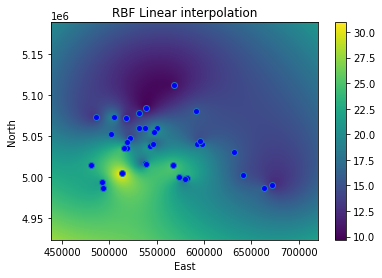

co_gdf


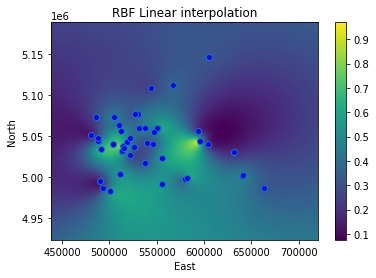

no2_gdf


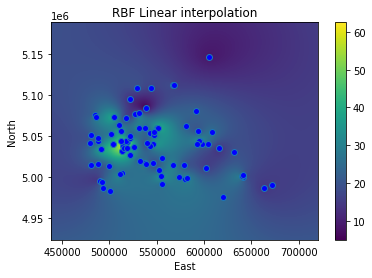

so2_gdf


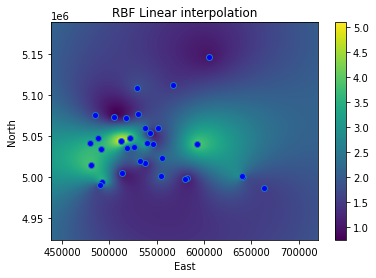

nh3_gdf


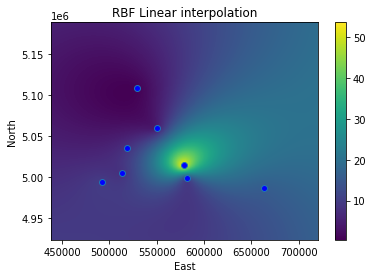

nox_gdf


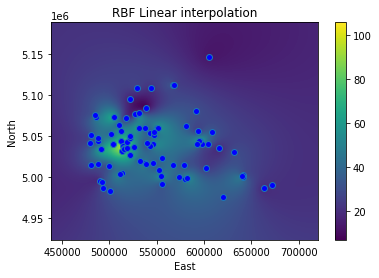

pm10_gdf


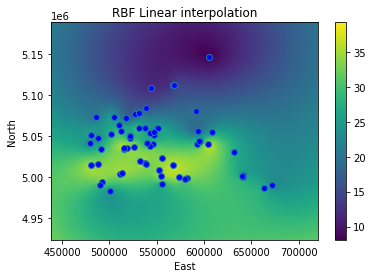

o3_gdf


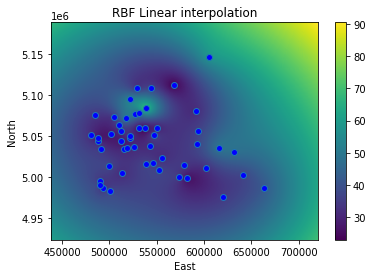

In [53]:
for key in aq_dict:
    east = aq_dict[key].geometry.x
    north = aq_dict[key].geometry.y
    value = aq_dict[key][['valore']]
    
    rbf = Rbf(east, north, value, function='linear')
    z_new = rbf(gridX.ravel(), gridY.ravel()).reshape(gridX.shape)
    print(key)
    plt.pcolor(gridX, gridY, z_new);
    plt.plot(east, north, 'o', markerfacecolor='blue');
    plt.xlabel('East'); plt.ylabel('North');
    plt.title('RBF Linear interpolation');
    plt.colorbar()
    plt.show()

    transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)

    new_dataset = rio.open(cwd +'/temp/aq_rbf_'+key[:(len(key)-4)]+'.tif', 'w', driver='GTiff',
                            height = z_new.shape[0], width = z_new.shape[1],
                            count=1, dtype=str(z_new.dtype),
                            crs='+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

    new_dataset.write(z_new, 1)
    new_dataset.close()
    #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
    ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/aq_rbf_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
                   outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)
    

temp_gdf


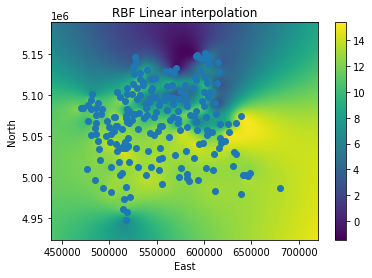

prec_gdf


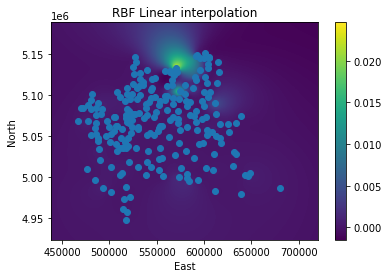

air_hum_gdf


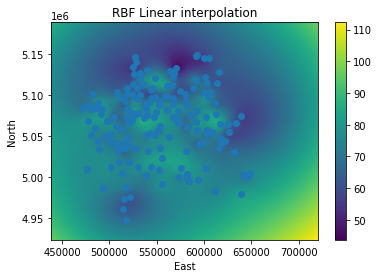

wind_dir_gdf


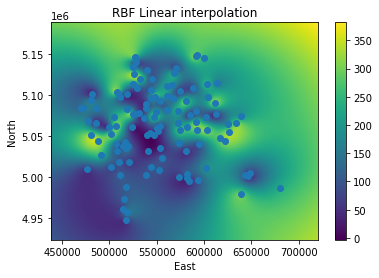

wind_speed_gdf


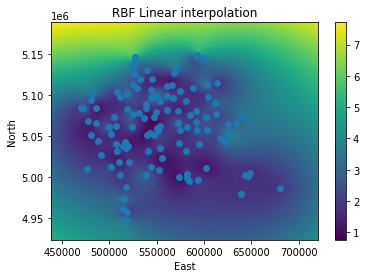

rad_glob_gdf


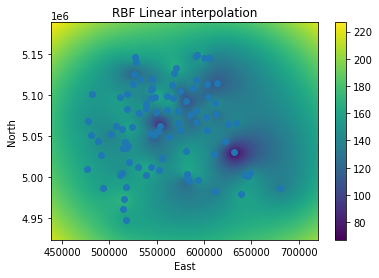

In [54]:
for key in meteo_dict:
    east = meteo_dict[key].geometry.x
    north = meteo_dict[key].geometry.y
    value = meteo_dict[key][['valore']]
    
    rbf = Rbf(east, north, value, function='linear')
    z_new = rbf(gridX.ravel(), gridY.ravel()).reshape(gridX.shape)
    print(key)
    plt.pcolor(gridX, gridY, z_new);
    plt.plot(east, north, 'o');
    plt.xlabel('East'); plt.ylabel('North');
    plt.title('RBF Linear interpolation');
    plt.colorbar()
    plt.show()

    transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)

    new_dataset = rio.open(cwd +'/temp/meteo_rbf_'+key[:(len(key)-4)]+'.tif', 'w', driver='GTiff',
                            height = z_new.shape[0], width = z_new.shape[1],
                            count=1, dtype=str(z_new.dtype),
                            crs='+proj=utm +zone=32 +datum=WGS84 +units=m +no_defs',
                            transform=transform)

    new_dataset.write(z_new, 1)
    new_dataset.close()
    #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
    ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/meteo_rbf_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
                   outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)

Statistics, Points Sampling with stations positions and rasters:

Data name : pm25_gdf
Max value from stations: 31.0
Max value from interpolated raster: 30.947097859469437
Min value from stations: 9.666666666666666
Min value from interpolated raster: 9.692675670145107
RMSE max: 0.47287868345815554
RMSE mean : 0.05285806229777284


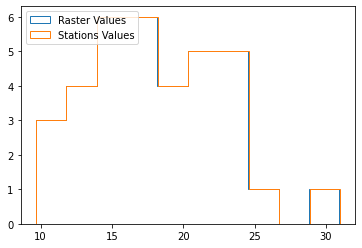

----------------------------------
Data name : co_gdf
Max value from stations: 0.9723502304147466
Max value from interpolated raster: 0.9691795860171872
Min value from stations: 0.11742424242424243
Min value from interpolated raster: 0.12056950740588057
RMSE max: 0.011793712522333633
RMSE mean : 0.0020797947321861223


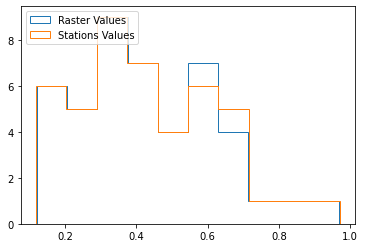

----------------------------------
Data name : no2_gdf
Max value from stations: 62.70326530612245
Max value from interpolated raster: 62.538349041159904
Min value from stations: 4.828787878787878
Min value from interpolated raster: 4.980769471770827
RMSE max: 1.2207557947986274
RMSE mean : 0.17537921886907873


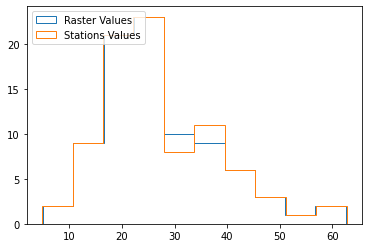

----------------------------------
Data name : so2_gdf
Max value from stations: 5.105725190839695
Max value from interpolated raster: 5.102810858841249
Min value from stations: 0.7378787878787879
Min value from interpolated raster: 0.7508225709781025
RMSE max: 0.05699042153255984
RMSE mean : 0.007840320310978123


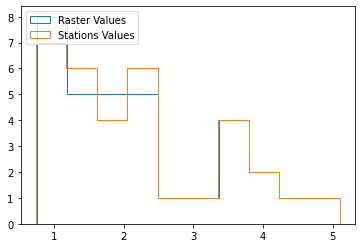

----------------------------------
Data name : nh3_gdf
Max value from stations: 53.63333333333333
Max value from interpolated raster: 53.56979317032484
Min value from stations: 0.5428571428571428
Min value from interpolated raster: 0.541852464431873
RMSE max: 0.06354016300848997
RMSE mean : 0.02100072807700694


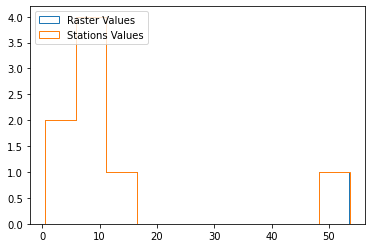

----------------------------------
Data name : nox_gdf
Max value from stations: 106.11255411255411
Max value from interpolated raster: 105.67360857402673
Min value from stations: 6.922727272727272
Min value from interpolated raster: 7.177929567736555
RMSE max: 2.7833100821008685
RMSE mean : 0.34238017105602075


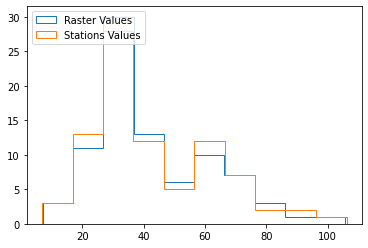

----------------------------------
Data name : pm10_gdf
Max value from stations: 39.54545454545455
Max value from interpolated raster: 39.23456963509088
Min value from stations: 8.090909090909092
Min value from interpolated raster: 8.100157133504808
RMSE max: 0.7198265016613661
RMSE mean : 0.0776799670920878


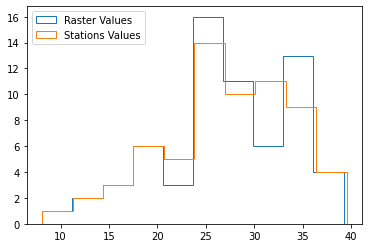

----------------------------------
Data name : o3_gdf
Max value from stations: 71.7128787878788
Max value from interpolated raster: 71.48764645659605
Min value from stations: 22.93375
Min value from interpolated raster: 23.020439625533484
RMSE max: 0.22523233128274
RMSE mean : 0.05232974727716597


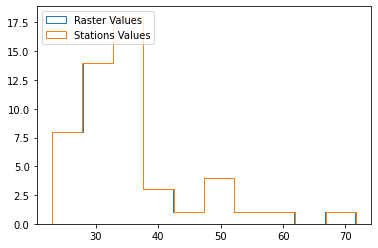

----------------------------------


In [55]:
for key in aq_dict:
    raster = rio.open(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif')
    east = aq_dict[key].geometry.x
    north = aq_dict[key].geometry.y
    value = aq_dict[key][['valore']]
    aq_dict[key].index = range(len(aq_dict[key]))
    coords = [(x,y) for x, y in zip(aq_dict[key].geometry.x,aq_dict[key].geometry.y)]
    aq_dict[key]['Raster Value'] = [x[0] for x in raster.sample(coords)]
    rmse = ((aq_dict[key]['Raster Value'] - aq_dict[key]['valore'])**2)**(1/2)
    print("Data name : {name}".format(name = key))
    print("Max value from stations: {value}".format(value = aq_dict[key]['valore'].max()))
    print("Max value from interpolated raster: {value}".format(value=aq_dict[key]['Raster Value'].max()))
    print("Min value from stations: {value}".format(value = aq_dict[key]['valore'].min()))
    print("Min value from interpolated raster: {value}".format(value=aq_dict[key]['Raster Value'].min()))
    print("RMSE max: {rmse}".format(rmse = rmse.max()))
    print("RMSE mean : {rmse}".format(rmse = rmse.mean()))
    plt.hist(aq_dict[key]['Raster Value'], label = 'Raster Values', histtype='step')
    plt.hist(aq_dict[key]['valore'], label = 'Stations Values', histtype='step')
    plt.legend(loc="upper left")
    plt.show()
    print("----------------------------------")
    

Data name : temp_gdf
Max value from stations: 15.415656565656567
Max value from interpolated raster: 15.394818567056888
Min value from stations: -1.4787113076437146
Min value from interpolated raster: -1.3902138692484272
RMSE max: 0.15420822780501808
RMSE mean : 0.02763236642408818


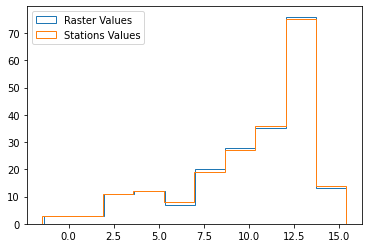

----------------------------------
Data name : prec_gdf
Max value from stations: 0.02474747474747475
Max value from interpolated raster: 0.024093581900110336
Min value from stations: 0.0
Min value from interpolated raster: -4.548910491443403e-05
RMSE max: 0.0006538928473644144
RMSE mean : 1.2843988135242959e-05


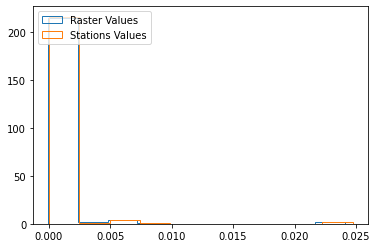

----------------------------------
Data name : air_hum_gdf
Max value from stations: 90.67113076437144
Max value from interpolated raster: 90.54214519687895
Min value from stations: 43.64560960202148
Min value from interpolated raster: 43.93996677702262
RMSE max: 1.0039946364578825
RMSE mean : 0.09677185709332314


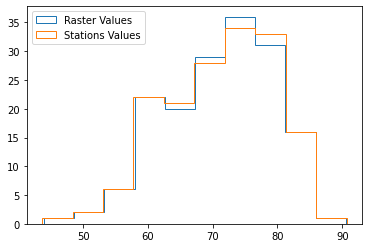

----------------------------------
Data name : wind_dir_gdf
Max value from stations: 359.0
Max value from interpolated raster: 357.3886674257949
Min value from stations: 0.1
Min value from interpolated raster: 0.03257909457852293
RMSE max: 5.674459717901755
RMSE mean : 0.9544340489100618


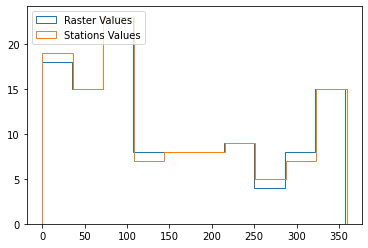

----------------------------------
Data name : wind_speed_gdf
Max value from stations: 5.749224405377456
Max value from interpolated raster: 5.720965162610188
Min value from stations: 0.7515151515151516
Min value from interpolated raster: 0.7600933906946725
RMSE max: 0.06182640128570682
RMSE mean : 0.008520864210208697


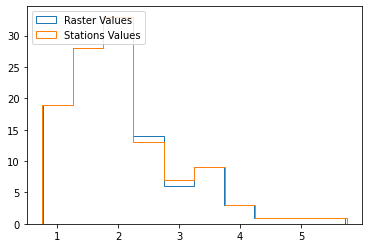

----------------------------------
Data name : rad_glob_gdf
Max value from stations: 172.1300505050505
Max value from interpolated raster: 171.9223616041849
Min value from stations: 66.79356060606061
Min value from interpolated raster: 67.00503091984862
RMSE max: 1.0405676536302053
RMSE mean : 0.14606295011248843


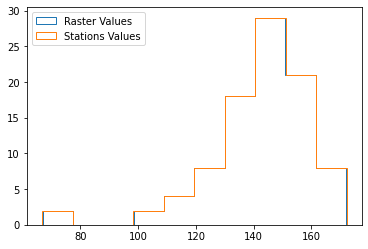

----------------------------------


In [56]:
for key in meteo_dict:
    raster = rio.open(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif')
    east = meteo_dict[key].geometry.x
    north = meteo_dict[key].geometry.y
    value = meteo_dict[key][['valore']]
    meteo_dict[key].index = range(len(meteo_dict[key]))
    coords = [(x,y) for x, y in zip(meteo_dict[key].geometry.x, meteo_dict[key].geometry.y)]
    meteo_dict[key]['Raster Value'] = [x[0] for x in raster.sample(coords)]
    rmse = ((meteo_dict[key]['Raster Value'] - meteo_dict[key]['valore'])**2)**(1/2)
    print("Data name : {name}".format(name = key))
    print("Max value from stations: {value}".format(value = meteo_dict[key]['valore'].max()))
    print("Max value from interpolated raster: {value}".format(value=meteo_dict[key]['Raster Value'].max()))
    print("Min value from stations: {value}".format(value = meteo_dict[key]['valore'].min()))
    print("Min value from interpolated raster: {value}".format(value=meteo_dict[key]['Raster Value'].min()))
    print("RMSE max: {rmse}".format(rmse = rmse.max()))
    print("RMSE mean : {rmse}".format(rmse = rmse.mean()))
    plt.hist(meteo_dict[key]['Raster Value'], label = 'Raster Values', histtype='step')
    plt.hist(meteo_dict[key]['valore'], label = 'Stations Values', histtype='step')
    plt.legend(loc="upper left")
    plt.show()
    print("----------------------------------")
        

# ESA LPS Air Quality Platform data request notebook

This notebook is used to download data from both meteorological and air quality ground sensor of LPS Air Quality Platform data.

The data are retrieved using the API service.
The sensors available are: 
- PM2.5
- PM10
- NO2
- CO2
- NH3
- CO
- Temperature
- Humidity

The API request downloads the data in the given time range. A Z-Score test is performed to remove outliers and the mean value for each sensor is calculated.
Mean values for each sensor are saved in geopackage format.

### Reference website: 
- ESA LPS Air Quality Platform: https://aqp.eo.esa.int/aqstation/
- ESA LPS Air Quality Platform sensor map: https://aqp.eo.esa.int/map/

In [57]:
device_list = [16, 36]  #list of devices considered to make the request 

In [58]:
aq_data = []

In [59]:
for i in range(len(device_list)):
    url = 'https://api.aqp.eo.esa.int/api/device/'+str(device_list[i])+'/csv?start_date='+start_date+'&end_date='+end_date
    urlData = requests.get(url).content
    rawData = pd.read_csv(io.StringIO(urlData.decode('utf-8')))
    aq_data.append(rawData)

df_data = pd.concat((pd.DataFrame(data) for data in aq_data), ignore_index=True)

In [60]:
sel_columns = ['device_id', 'acquisition_date','latitude', 
           'longitude', 'pm25', 'pm10', 'humidity', 'temperature',
          'no2', 'co2', 'nh3', 'co']

In [61]:
df_data.device_id.unique()

array([16, 36], dtype=int64)

In [62]:
aq_data = df_data[sel_columns]

In [63]:
aq_data['acquisition_date'] = pd.to_datetime(aq_data['acquisition_date'], format='%Y-%m-%d %H:%M:%S')

In [64]:
pm25 = aq_data[['device_id','acquisition_date', 'latitude', 'longitude', 'pm25']]
pm10 = aq_data[['device_id','acquisition_date', 'latitude', 'longitude', 'pm10']]
humidity = aq_data[['device_id','acquisition_date', 'latitude', 'longitude', 'humidity']]
temperature = aq_data[['device_id','acquisition_date', 'latitude', 'longitude', 'temperature']]
no2 = aq_data[['device_id','acquisition_date', 'latitude', 'longitude', 'no2']]
co2 = aq_data[['device_id','acquisition_date', 'latitude', 'longitude', 'co2']]
nh3 = aq_data[['device_id','acquisition_date', 'latitude', 'longitude', 'nh3']]
co = aq_data[['device_id','acquisition_date', 'latitude', 'longitude', 'co']]

In [65]:
pm25 = pm25.rename(columns={'pm25': 'value'})
pm10 = pm10.rename(columns={'pm10': 'value'})
humidity = humidity.rename(columns={'humidity': 'value'})
temperature = temperature.rename(columns={'temperature': 'value'})
no2 = no2.rename(columns={'no2': 'value'})
co2 = co2.rename(columns={'co2': 'value'})
nh3 = nh3.rename(columns={'nh3': 'value'})
co = co.rename(columns={'co': 'value'})

In [66]:
pm25

device_id    acquisition_date   latitude  longitude  value
0             16 2021-10-07 00:01:06  45.477748   9.227293    0.0
1             16 2021-10-07 00:02:15  45.477748   9.227293    0.3
2             16 2021-10-07 00:03:20  45.477748   9.227293    0.3
3             16 2021-10-07 00:04:27  45.477748   9.227293    0.0
4             16 2021-10-07 00:05:33  45.477748   9.227293    0.1
...          ...                 ...        ...        ...    ...
31567         36 2021-10-18 23:55:28  45.534771  10.231425    2.1
31568         36 2021-10-18 23:56:33  45.534771  10.231425    2.0
31569         36 2021-10-18 23:57:37  45.534771  10.231425    2.0
31570         36 2021-10-18 23:58:42  45.534771  10.231425    2.0
31571         36 2021-10-18 23:59:46  45.534771  10.231425    2.1

[31572 rows x 5 columns]

In [67]:
pm25['zscore'] = np.abs(stats.zscore(pm25['value'], nan_policy='omit'))
pm25 = pm25[pm25.zscore < threshold]
pm25 = pm25.groupby(['device_id'],as_index=False).mean()

In [68]:
pm10['zscore'] = np.abs(stats.zscore(pm10['value'], nan_policy='omit'))
pm10 = pm10[pm10.zscore < threshold]
pm10 = pm10.groupby(['device_id'],as_index=False).mean()

In [69]:
humidity['zscore'] = np.abs(stats.zscore(humidity['value'], nan_policy='omit'))
humidity = humidity[humidity.zscore < threshold]
humidity = humidity.groupby(['device_id'],as_index=False).mean()

In [70]:
temperature['zscore'] = np.abs(stats.zscore(temperature['value'], nan_policy='omit'))
temperature = temperature[temperature.zscore < threshold]
temperature = temperature.groupby(['device_id'],as_index=False).mean()

In [71]:
no2['zscore'] = np.abs(stats.zscore(no2['value'], nan_policy='omit'))
no2 = no2[no2.zscore < threshold]
no2 = no2.groupby(['device_id'],as_index=False).mean()

In [72]:
co2['zscore'] = np.abs(stats.zscore(co2['value'], nan_policy='omit'))
co2 = co2[co2.zscore < threshold]
co2 = co2.groupby(['device_id'],as_index=False).mean()

In [73]:
nh3['zscore'] = np.abs(stats.zscore(nh3['value'], nan_policy='omit'))
nh3 = nh3[nh3.zscore < threshold]
nh3 = nh3.groupby(['device_id'],as_index=False).mean()

In [74]:
co['zscore'] = np.abs(stats.zscore(co['value'], nan_policy='omit'))
co = co[co.zscore < threshold]
co = co.groupby(['device_id'],as_index=False).mean()

Create Geodataframe and save in geopackage:

In [75]:
pm25_gdf = gpd.GeoDataFrame(pm25, geometry=gpd.points_from_xy(pm25.longitude, pm25.latitude)).set_crs('epsg:4326')
pm10_gdf = gpd.GeoDataFrame(pm10, geometry=gpd.points_from_xy(pm10.longitude, pm10.latitude)).set_crs('epsg:4326')
hum_gdf = gpd.GeoDataFrame(humidity, geometry=gpd.points_from_xy(humidity.longitude, humidity.latitude)).set_crs('epsg:4326')
temp_gdf = gpd.GeoDataFrame(temperature, geometry=gpd.points_from_xy(temperature.longitude, temperature.latitude)).set_crs('epsg:4326')
no2_gdf = gpd.GeoDataFrame(no2, geometry=gpd.points_from_xy(no2.longitude, no2.latitude)).set_crs('epsg:4326')
co2_gdf = gpd.GeoDataFrame(co2, geometry=gpd.points_from_xy(co2.longitude, co2.latitude)).set_crs('epsg:4326')
nh3_gdf = gpd.GeoDataFrame(nh3, geometry=gpd.points_from_xy(nh3.longitude, nh3.latitude)).set_crs('epsg:4326')
co_gdf = gpd.GeoDataFrame(co, geometry=gpd.points_from_xy(co.longitude, co.latitude)).set_crs('epsg:4326')

In [76]:
pm25_gdf.to_file(cwd+"/temp/pm25_lcs.gpkg", driver="GPKG")
pm10_gdf.to_file(cwd+"/temp/pm10_lcs.gpkg", driver="GPKG")
hum_gdf.to_file(cwd+"/temp/hum_lcs.gpkg", driver="GPKG")
temp_gdf.to_file(cwd+"/temp/temp_lcs.gpkg", driver="GPKG")
no2_gdf.to_file(cwd+"/temp/no2_lcs.gpkg", driver="GPKG")
co2_gdf.to_file(cwd+"/temp/co2_lcs.gpkg", driver="GPKG")
nh3_gdf.to_file(cwd+"/temp/nh3_lcs.gpkg", driver="GPKG")
co_gdf.to_file(cwd+"/temp/co_lcs.gpkg", driver="GPKG")

----

In [77]:
# from pykrige.ok import OrdinaryKriging
# from pykrige.kriging_tools import write_asc_grid
# import pykrige.kriging_tools as kt

In [78]:
# for key in aq_dict:
#     east = aq_dict[key].geometry.x
#     north = aq_dict[key].geometry.y
#     value = aq_dict[key][['valore']]
#     n_sensor = aq_dict[key].shape[0]  #VERIFICARE nlags in funzione del numero di sensori (defaul 6)
#     lag = int(math.sqrt(n_sensor))
    
#     OK = OrdinaryKriging(east, north,value, weight=True,nlags= lag ,variogram_model='power',coordinates_type='euclidean') #verbose=True, enable_plotting=False, weight=w
#     # print(UniversalKriging.__doc__ )
#     gridded, ss1 = OK.execute('grid', xRange, yRange)
#     transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)
#     rasterCrs = CRS.from_epsg(32632)
#     #definition, register and close of interpolated raster
#     interpRaster = rio.open(cwd +'/temp/aq_krig_'+key[:(len(key)-4)]+'.tif',
#                                     'w',
#                                     driver='GTiff',
#                                     height=gridded.shape[0],
#                                     width=gridded.shape[1],
#                                     count=1,
#                                     nodata = -9999,
#                                     dtype=gridded.dtype,
#                                     crs=rasterCrs,
#                                     transform=transform,
#                                     )
#     interpRaster.write(gridded, 1)
#     interpRaster.close()
#     #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
#     ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/aq_krig_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
#                outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)
#     print(key)
#     plt.imshow(gridded)
#     plt.show()

In [79]:
# for key in meteo_dict:
#     east = meteo_dict[key].geometry.x
#     north = meteo_dict[key].geometry.y
#     value = meteo_dict[key][['valore']]
#     n_sensor = meteo_dict[key].shape[0]  #VERIFICARE nlags in funzione del numero di sensori (defaul 6)
#     lag = int(math.sqrt(n_sensor))
    
#     OK = OrdinaryKriging(east, north, value, nlags= lag,
#                  weight=True, variogram_model='power',coordinates_type='euclidean') #verbose=True, enable_plotting=False, weight=w
#     # print(OrdinaryKriging.__doc__)
#     gridded, ss1 = OK.execute('grid', xRange, yRange)
#     transform = Affine.translation(gridX[0][0]-rRes/2, gridY[0][0]-rRes/2)*Affine.scale(rRes,rRes)
#     rasterCrs = CRS.from_epsg(32632)
#     #definition, register and close of interpolated raster
#     interpRaster = rio.open(cwd +'/temp/meteo_krig_'+key[:(len(key)-4)]+'.tif',
#                                     'w',
#                                     driver='GTiff',
#                                     height= gridded.shape[0],
#                                     width= gridded.shape[1],
#                                     count=1,
#                                     nodata = -9999,
#                                     dtype=gridded.dtype,
#                                     crs=rasterCrs,
#                                     transform=transform,
#                                     )
#     interpRaster.write(gridded, 1)
#     interpRaster.close()
#     #Warp with GDAL since rasterio and rasterstats affine transformation don't work in the grid processing notebook
#     ds = gdal.Warp(cwd +'/temp/int_'+key[:(len(key)-4)]+'.tif', cwd +'/temp/meteo_krig_'+key[:(len(key)-4)]+'.tif', dstSRS='EPSG:32632',
#                outputType=gdal.GDT_Float64, xRes=rRes, yRes=rRes)
#     print(key)
#     print(lag)
#     plt.imshow(gridded)
#     plt.show()

Notes:

In [80]:
# INTERPOLATION USING GDAL
# pts = ogr.Open(cwd+'/temp/air_hum_st.gpkg', update = True)
# layer=pts.GetLayer()

# to generate a an interpolation using GDAL library
# pts = layer = None
# idw = gdal.Grid("idw.tif", (cwd+'/temp/air_hum_st.gpkg'), zfield="valore",
#                algorithm = "invdist", outputBounds = [ulx,uly,lrx,lry],
#                width = xsize, height = ysize)
# idw = None

# points = list(zip(air_hum_st.lng,air_hum_st.lat))

# gridded = griddata(points, value, (gridX,gridY), method='linear',fill_value=0)

# gridded = gridded.reshape((gridded.shape[0], gridded.shape[1]))

# plt.imshow(gridded)

In [81]:
#Mask data using date range
#mask = (meteo_data['data'] >= start_date) & (meteo_data['data'] < end_date)
#meteo_data = meteo_data.loc[mask]
#meteo_data

In [82]:
# print(list(arpa_df.columns))
# print(arpa_df['idsensore'].values)

In [83]:
# results = client.get_all(dati, idsensore = "100", data='2022-01-20')
# results

In [84]:
# arpa_df.loc[arpa_df['idsensore'] == "10377"]